In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import scipy.stats as stats
import pandas as pd
import pickle
import os
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.utils import resample

regions = {0: 'imgs', 1: 'caudate', 2: 'cerebellum', 3: 'frontal_lobe', 4: 'insula', 5: 'occipital_lobe', 6: 'parietal_lobe', 7: 'putamen', 8: 'temporal_lobe', 9: 'thalamus'}
root = '/media/leelabsg-storage1/yein/research/test/'
age_diff_groups = {}
cn_size = 25656
disease_l = 'z864'
disease_u = 'Z864'

In [17]:
def bias_correction(true, pred):
    reg = LinearRegression().fit(true.reshape(-1, 1), pred) # reshape to 2D array
    beta_0 = reg.intercept_
    beta_1 = reg.coef_[0]

    corrected_pred = (pred - beta_0) / beta_1
    return corrected_pred


def bias_correction_standard(true, pred):
    true = np.array(true).reshape(-1, 1)
    pred = np.array(pred).reshape(-1, 1)
    
    # StandardScaler를 사용하여 정규화
    scaler = StandardScaler()
    true_scaled = scaler.fit_transform(true)
    pred_scaled = scaler.transform(pred)
    
    # Linear Regression 모델을 사용하여 예측 차이를 보정
    reg = LinearRegression().fit(true_scaled, pred_scaled)
    beta_0 = reg.intercept_
    beta_1 = reg.coef_[0]
    
    corrected_pred = scaler.inverse_transform((pred_scaled - beta_0) / beta_1)
    
    return corrected_pred

def pickel_load_cn(root):
    map = dict()
    for _, v in regions.items():
        map[v] = {'pred_ages': [],
                 'true_ages': []}

    
    for cv_num in range(4):
        for content in ['pred_ages', 'true_ages']:
            pickel_path = os.path.join(root, str(cv_num), f'{content}.pickle')
            # print(pickel_path)
            with open(pickel_path, 'rb') as file:
                curr_cv = pickle.load(file) # cv-split size의 dict (region: age_lists)

            for _, v in regions.items():
                map[v][content].extend(curr_cv[v][0])

    return map

def pickle_load(root):
    map = {v: {'pred_ages': [], 'true_ages': []} for _, v in regions.items()}

    # true_ages 4-cv model results gathering for averaging them
    for cv_num in range(4):
        pickel_path = os.path.join(root, str(cv_num), 'true_ages.pkl')
        if os.path.exists(pickel_path):
            with open(pickel_path, 'rb') as file:
                curr_cv = pickle.load(file)  # cv-split size의 dict (region: age_lists)  # age_lists length: 630
                for region, age_list in curr_cv.items():
                    map[region]['true_ages'] = age_list
    
    # pred_ages 4-cv model results gathering for averaging them
    for cv_num in range(4):
        pickle_path = os.path.join(root, str(cv_num), 'pred_ages.pkl')
        if os.path.exists(pickle_path):
            with open(pickle_path, 'rb') as file:
                curr_cv = pickle.load(file)
                for region, age_list in curr_cv.items():
                    map[region]['pred_ages'].append(age_list)

    for region, _ in map.items():
        pred_ages_lists = map[region]['pred_ages']
        pred_avg_age = [sum(values) / len(values) for values in zip(*pred_ages_lists)]
        map[region]['pred_ages'] = pred_avg_age

    
    for region, age_list in map.items():
        print(region, len(map[region]['true_ages']), len(map[region]['pred_ages']))

    print("=" * 30)
    return map          

def age_dist_plot(region, cn, disease):
    plt.figure(figsize=(12, 8))
    plt.hist(cn[region]['true_ages'], bins=30, alpha=0.6, label='CN', density=True, edgecolor='black', color='#2986cc')
    plt.hist(disease[region]['true_ages'], bins=30, alpha=0.4, label=disease_u, density=True, edgecolor='black', color='#cc0000')
    plt.title('Age Distribution by Group', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.show()

def age_dist_plot_single_group(region, group):
    plt.figure(figsize=(12, 8))
    plt.hist(group[region]['true_ages'], bins=30, alpha=0.6, label='True', density=True, edgecolor='black', color='#2986cc')
    plt.hist(group[region]['pred_ages'], bins=30, alpha=0.4, label='Pred', density=True, edgecolor='black', color='#ffa833')
    plt.hist(group[region]['corrected_pred_ages'], bins=30, alpha=0.4, label='Corrected Pred', density=True, edgecolor='black', color='#cc0000')
    plt.title('Age Distribution by Group', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.show()

def age_dist_re_counts(region, cn, re_cn):
    plt.figure(figsize=(12, 8))
    # density=True를 제거하여 실제 값이 표시되도록 합니다.
    plt.hist(cn[region]['true_ages'], bins=30, alpha=0.6, label='CN', edgecolor='black', color='#2986cc')
    plt.hist(re_cn[region]['true_ages'], bins=30, alpha=0.4, label='Resampled_CN', edgecolor='black', color='#ffa833')
    plt.title('Age Distribution by Group', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Counts', fontsize=14)  # "Density"를 "Counts"로 변경
    plt.legend(loc='upper right', fontsize=12)
    plt.show()

def age_dist_plot_counts(region, cn, disease):
    plt.figure(figsize=(12, 8))
    plt.hist(cn[region]['true_ages'], bins=30, alpha=0.6, label='CN', edgecolor='black', color='#2986cc')
    plt.hist(disease[region]['true_ages'], bins=30, alpha=0.4, label=disease_u, edgecolor='black', color='#cc0000')
    plt.title('Age Distribution by Group', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.show()

def age_dist_plot_pred(region, cn, disease):
    plt.figure(figsize=(12, 8))
    plt.hist(cn[region]['pred_ages'], bins=30, alpha=0.6, label='CN', density=True, edgecolor='black', color='#2986cc')
    plt.hist(disease[region]['pred_ages'], bins=30, alpha=0.4, label=disease_u, density=True, edgecolor='black', color='#cc0000')
    plt.title('Age Distribution by Group', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.show()

def age_dist_plot_pred_counts(region, cn, disease):
    plt.figure(figsize=(12, 8))
    plt.hist(cn[region]['pred_ages'], bins=30, alpha=0.6, label='CN', edgecolor='black', color='#2986cc')
    plt.hist(disease[region]['pred_ages'], bins=30, alpha=0.4, label=disease_u, edgecolor='black', color='#cc0000')
    plt.title('Age Distribution by Group', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.show()

def age_plot(data, region):
    true = data[region]['true_ages']
    pred = data[region]['pred_ages']
    if region == 'imgs':
        region = 'global'
    plt.figure(figsize=(7, 5))
    plt.scatter(true, pred, alpha=0.2)
    plt.plot([min(true), max(true)], [min(true), max(true)], color='red')  # y=x line
    plt.title(f'{region} ========== True Age and Predicted Age')
    plt.xlabel('True_Age')
    plt.ylabel('Predicted_Age')
    plt.show()

def age_plot_corrected(data, region):
    true = data[region]['true_ages']
    pred = data[region]['pred_ages']
    if region == 'imgs':
        region = 'global'
    plt.figure(figsize=(7, 5))
    plt.scatter(true, pred, alpha=0.2)
    plt.plot([min(true), max(true)], [min(true), max(true)], color='red')  # y=x line
    plt.title(f'{region} ========== True Age and Corrected Predicted Age')
    plt.xlabel('True_Age')
    plt.ylabel('Predicted_Age')
    plt.show()

def age_diff_plot(age_diff_dict, regions):
    fig, ax = plt.subplots(figsize=(12, 8))

    age_diff_max = max(abs(max(age_diff_dict.values())), abs(min(age_diff_dict.values())))

    cmap = plt.get_cmap('coolwarm')
    norm = mcolors.Normalize(vmin=-age_diff_max, vmax=age_diff_max)

    for region, age_diff in age_diff_dict.items():
        color = cmap(norm(age_diff))
        ax.barh(region, age_diff, color=color)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('PAD (years)')

    ax.set_xlabel('Predicted Age Difference (years)')
    ax.set_title('Regional Predicted Age Difference (PAD)')
    plt.show()

# 예측 연령 차이 계산
def calculate_age_diff_avg(data, region):
    pred_ages = np.array(data[region]['pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    return np.mean(pred_ages - true_ages)

def calculate_corrected_age_diff_avg(data, region):
    corrected_pred_ages = np.array(data[region]['corrected_pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    avg_diff = np.mean(corrected_pred_ages - true_ages)
    return np.round(avg_diff, 7)

def calculate_age_diff_dist(data, region):
    corrected_pred_ages = np.array(data[region]['corrected_pred_ages'])
    true_ages = np.array(data[region]['true_ages'])
    diff = calculate_corrected_age_diff_avg(data, region)

    plt.hist(corrected_pred_ages, bins=30, alpha=0.5, label='Predicted', density=True, edgecolor='black', color='red')
    plt.hist(true_ages, bins=30, alpha=0.5, label='True', density=True, edgecolor='black', color='grey')
    # plt.hist(diff, bins=30, alpha=0.5, label='Difference', density=True, edgecolor='black')
    plt.title('Age Difference Distribution')
    plt.xlabel('Age Difference')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.show()


def cn_resampling(cn, disease):
    
    new_cn_ages = dict()

    for _, reg in regions.items():  
        print(reg, flush=True)
        
        cn_ages_np = np.array(cn[reg]['true_ages'])
        disease_ages_np = np.array(disease[reg]['true_ages'])
        print(cn_ages_np.size, disease_ages_np.size)
        
        # disease_ages의 분포를 추정하기 위해 Kernel Density Estimation (KDE) 사용
        kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(disease_ages_np.reshape(-1, 1))
        
        # cn_ages에서 disease_ages의와 비슷한 분포를 가지도록 샘플링
        log_densities = kde.score_samples(cn_ages_np.reshape(-1, 1))
        probabilities = np.exp(log_densities)
        print(f'log_densities: {log_densities}, probabilities: {probabilities}')
        
        # cn_ages의 샘플링 확률을 disease_ages의 분포에 맞추어 정규화
        probabilities /= probabilities.sum()
        print(f'regularized probabilities: {probabilities}')
        
        # cn_ages의에서 disease_ages의와 비슷한 분포를 가지는 sample indices
        sampled_indices = np.random.choice(np.arange(len(cn_ages_np)), size=len(disease_ages_np), p=probabilities, replace=False)
        print(sampled_indices)
        print("="*30)
        
        cn_ages_true_np = np.array(cn[reg]['true_ages'])
        cn_ages_pred_np = np.array(cn[reg]['pred_ages'])
        print(cn_ages_true_np.shape, cn_ages_pred_np.shape, flush=True) # (25656,) (25656,)
        
        sampled_true_np = cn_ages_true_np[sampled_indices]
        sampled_pred_np = cn_ages_pred_np[sampled_indices]
       
        # 결과 확인
        print(f"Sampled size of True after Resampling: {len(sampled_true_np)}", flush=True) # 3118
        print(f"Sampled size of Pred after Resampling: {len(sampled_pred_np)}", flush=True) # 3118
        print("=" * 30)

        ages = {
            'true_ages': list(sampled_true_np),
            'pred_ages': list(sampled_pred_np)
        }
        new_cn_ages[reg] = ages

    return new_cn_ages

In [18]:
cn_root = root + 'ukb'
cn_ages = pickel_load_cn(cn_root)
disease_root = root + f'ukb_{disease_l}'
disease_ages = pickle_load(disease_root)
disease_len = len(disease_ages['imgs']['true_ages'])
print(len(cn_ages['imgs']['true_ages']), disease_len)

imgs 2231 2231
caudate 2231 2231
cerebellum 2231 2231
frontal_lobe 2231 2231
insula 2231 2231
occipital_lobe 2231 2231
parietal_lobe 2231 2231
putamen 2231 2231
temporal_lobe 2231 2231
thalamus 2231 2231
25656 2231


In [19]:
re_cn_ages = cn_resampling(cn_ages, disease_ages)

imgs
25656 2231
log_densities: [-3.49650695 -2.72828326 -2.75239132 ... -2.81560687 -2.72828326
 -2.71478339], probabilities: [0.03030305 0.06533135 0.06377517 ... 0.05986838 0.06533135 0.0662193 ]
regularized probabilities: [3.24394120e-05 6.99372067e-05 6.82713182e-05 ... 6.40890927e-05
 6.99372067e-05 7.08877521e-05]
[ 7874 14675  4776 ... 20905  8164  3406]
(25656,) (25656,)
Sampled size of True after Resampling: 2231
Sampled size of Pred after Resampling: 2231
caudate
25656 2231
log_densities: [-3.49650695 -2.72828326 -2.75239132 ... -2.81560687 -2.72828326
 -2.71478339], probabilities: [0.03030305 0.06533135 0.06377517 ... 0.05986838 0.06533135 0.0662193 ]
regularized probabilities: [3.24394120e-05 6.99372067e-05 6.82713182e-05 ... 6.40890927e-05
 6.99372067e-05 7.08877521e-05]
[ 4097 23616 16891 ...  1832 23329   607]
(25656,) (25656,)
Sampled size of True after Resampling: 2231
Sampled size of Pred after Resampling: 2231
cerebellum
25656 2231
log_densities: [-3.49650695 -2.7282

# age distribution by group

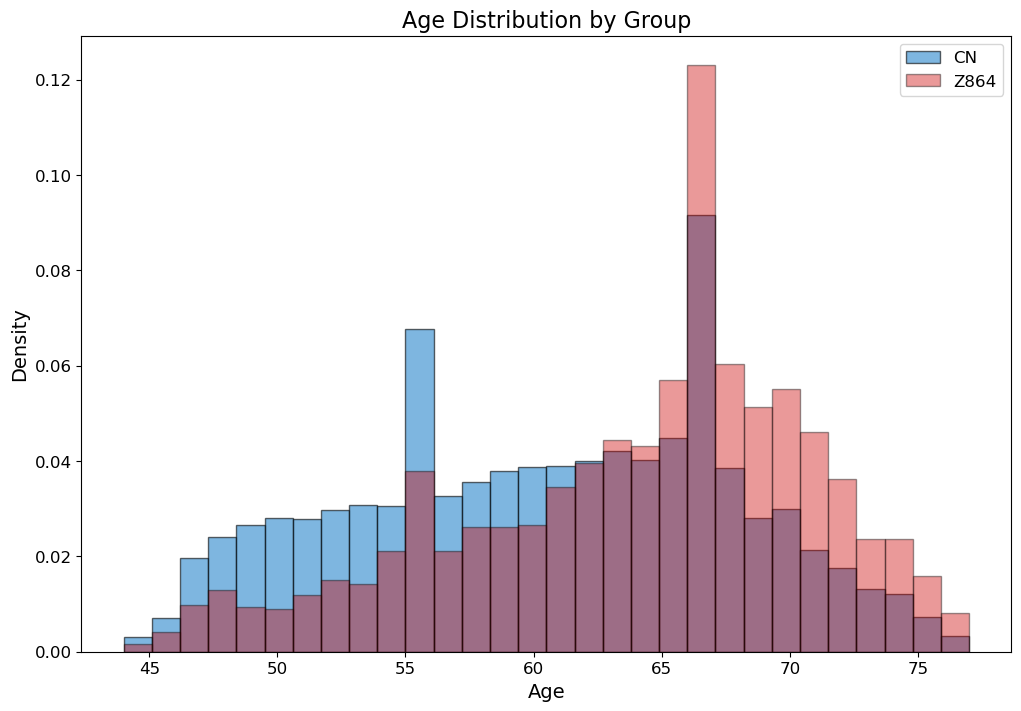

In [20]:
age_dist_plot('imgs', cn_ages, disease_ages)

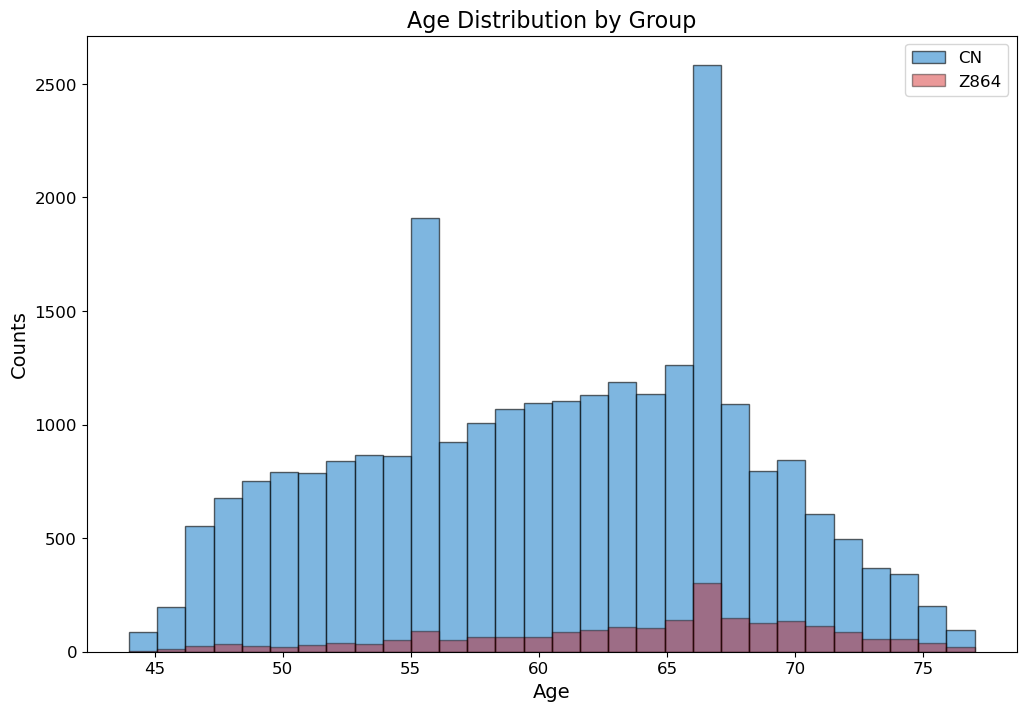

In [21]:
age_dist_plot_counts('imgs', cn_ages, disease_ages)

In [8]:
cn_df = pd.DataFrame(cn_ages['imgs'])
cn_df['true_ages'].describe()

count    25656.000000
mean        60.416004
std          7.382716
min         44.000000
25%         54.750000
50%         61.000000
75%         66.000000
max         77.000000
Name: true_ages, dtype: float64

In [9]:
disease_df = pd.DataFrame(disease_ages['imgs'])
disease_df['true_ages'].describe()

count    2231.000000
mean       63.990139
std         6.901933
min        44.000000
25%        60.000000
50%        65.000000
75%        69.000000
max        77.000000
Name: true_ages, dtype: float64

In [10]:
re_cn_df = pd.DataFrame(re_cn_ages['imgs'])
re_cn_df['true_ages'].describe()

count    2231.000000
mean       63.386822
std         5.925743
min        45.000000
25%        60.000000
50%        65.000000
75%        68.000000
max        75.000000
Name: true_ages, dtype: float64

In [36]:
regions_name = list(regions.values())
ukbb_regions_ages = dict()

for idx, region in enumerate(regions_name):
    print(region)
    ages = {
        'pred': [],
        'true': []
    }
    ukbb_regions_ages.setdefault(region, ages)
    ukbb_regions_ages[region]['pred'].extend(cn_ages[region]['pred_ages']) # 25656
    ukbb_regions_ages[region]['true'].extend(cn_ages[region]['true_ages'])
    ukbb_regions_ages[region]['pred'].extend(re_cn_ages[region]['pred_ages']) # 3118
    ukbb_regions_ages[region]['true'].extend(re_cn_ages[region]['true_ages'])
    ukbb_regions_ages[region]['pred'].extend(disease_ages[region]['pred_ages']) # 3118
    ukbb_regions_ages[region]['true'].extend(disease_ages[region]['true_ages'])

    true = np.array(ukbb_regions_ages[region]['true'])
    pred = np.array(ukbb_regions_ages[region]['pred'])
    ukbb_regions_ages[region]['corrected_pred'] = bias_correction(true, pred)
    print(len(ukbb_regions_ages[region]), len(ukbb_regions_ages[region]['true']), len(ukbb_regions_ages[region]['pred']), len(ukbb_regions_ages[region]['corrected_pred']))

    cn_ages[region]['corrected_pred_ages'] = ukbb_regions_ages[region]['corrected_pred'][:cn_size]
    re_cn_ages[region]['corrected_pred_ages'] = ukbb_regions_ages[region]['corrected_pred'][cn_size:cn_size+disease_len]
    disease_ages[region]['corrected_pred_ages'] = ukbb_regions_ages[region]['corrected_pred'][cn_size+disease_len:]

    print(len(cn_ages[region]['corrected_pred_ages']), len(re_cn_ages[region]['corrected_pred_ages']), len(disease_ages[region]['corrected_pred_ages']))
    print("=" * 20)

imgs
3 30118 30118 30118
25656 2231 2231
caudate
3 30118 30118 30118
25656 2231 2231
cerebellum
3 30118 30118 30118
25656 2231 2231
frontal_lobe
3 30118 30118 30118
25656 2231 2231
insula
3 30118 30118 30118
25656 2231 2231
occipital_lobe
3 30118 30118 30118
25656 2231 2231
parietal_lobe
3 30118 30118 30118
25656 2231 2231
putamen
3 30118 30118 30118
25656 2231 2231
temporal_lobe
3 30118 30118 30118
25656 2231 2231
thalamus
3 30118 30118 30118
25656 2231 2231


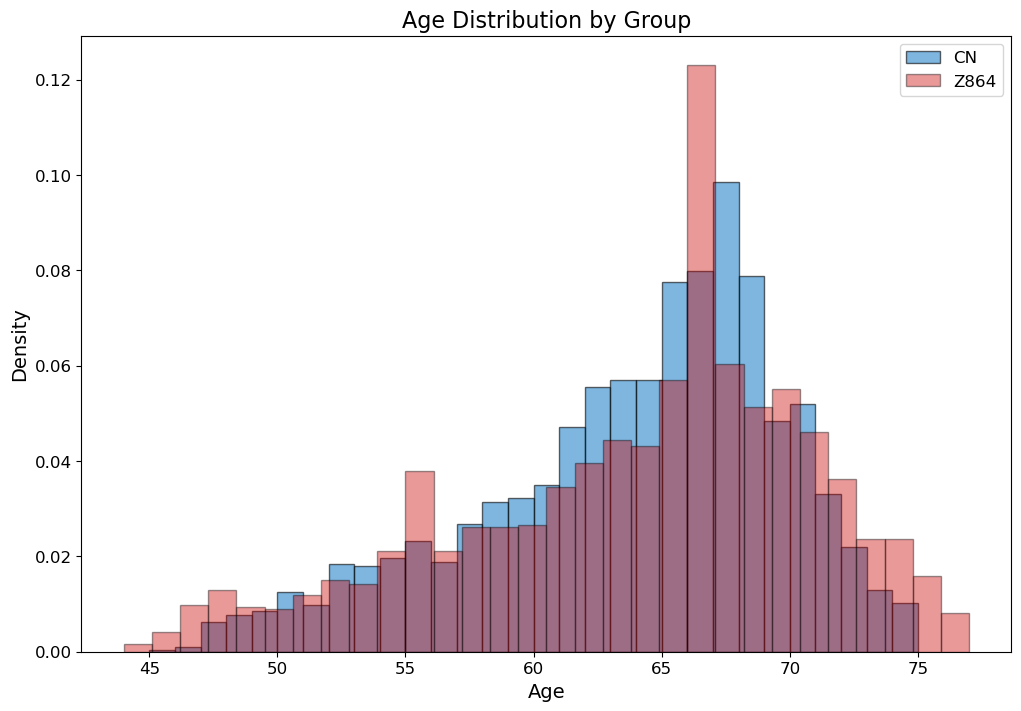

In [12]:
age_dist_plot('imgs', re_cn_ages, disease_ages)

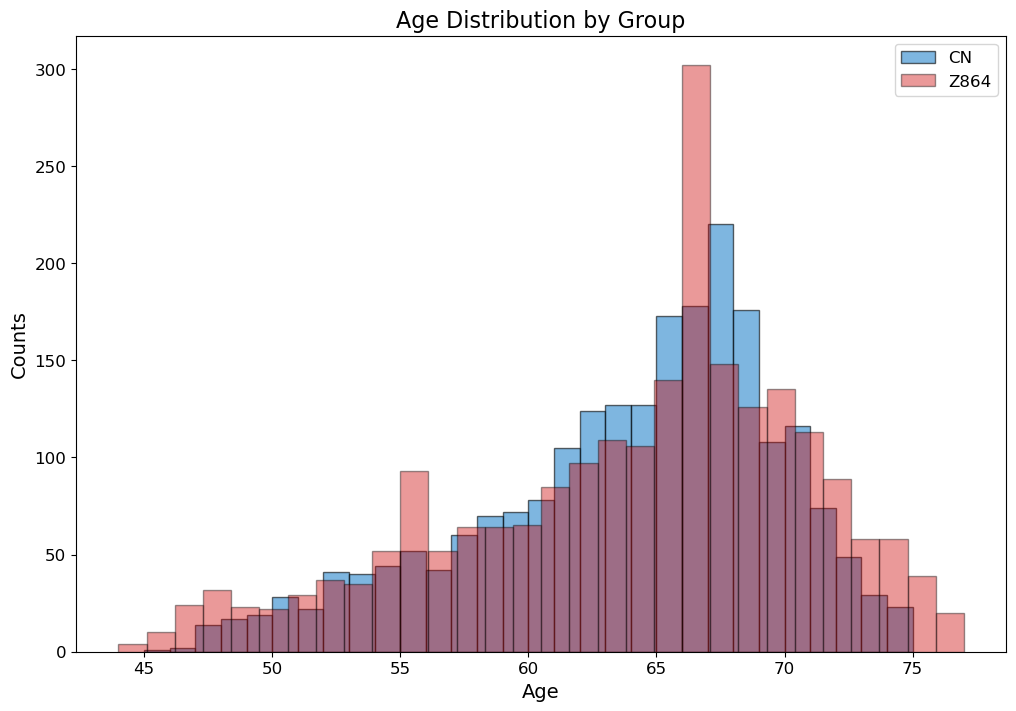

In [13]:
age_dist_plot_counts('imgs', re_cn_ages, disease_ages)

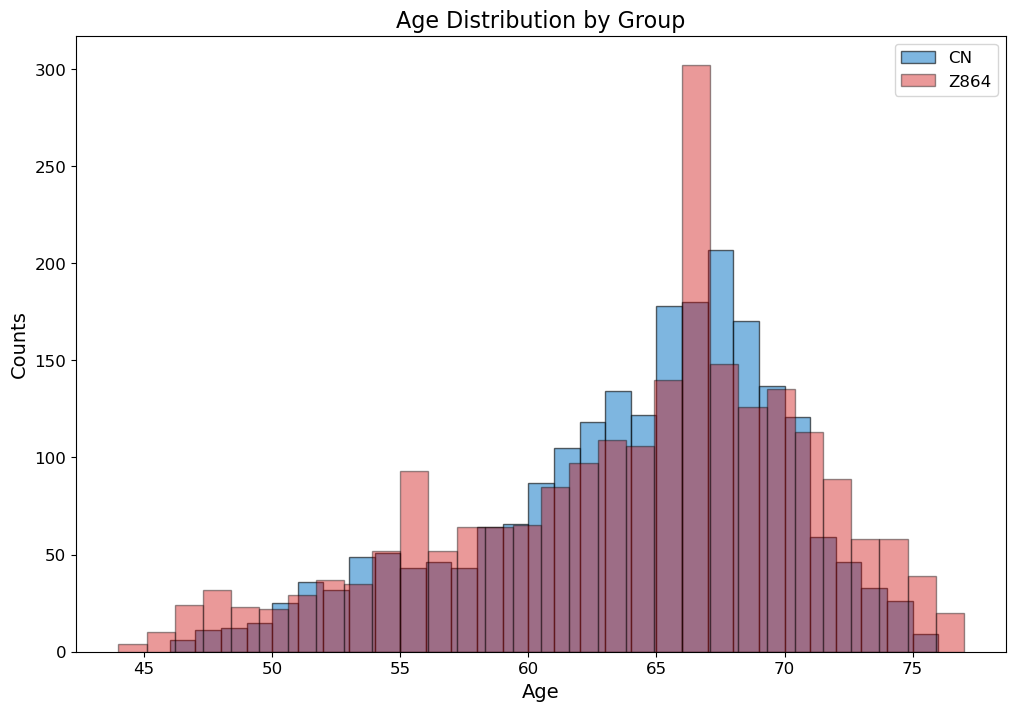

In [14]:
age_dist_plot_counts('cerebellum', re_cn_ages, disease_ages)

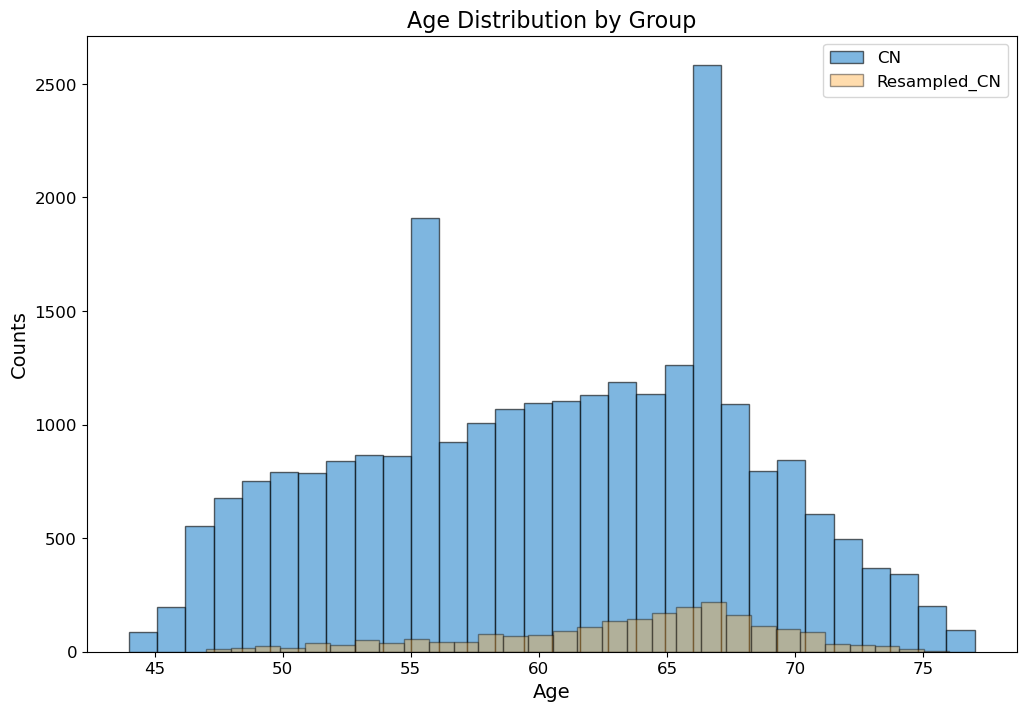

In [22]:
age_dist_re_counts('imgs', cn_ages, re_cn_ages)

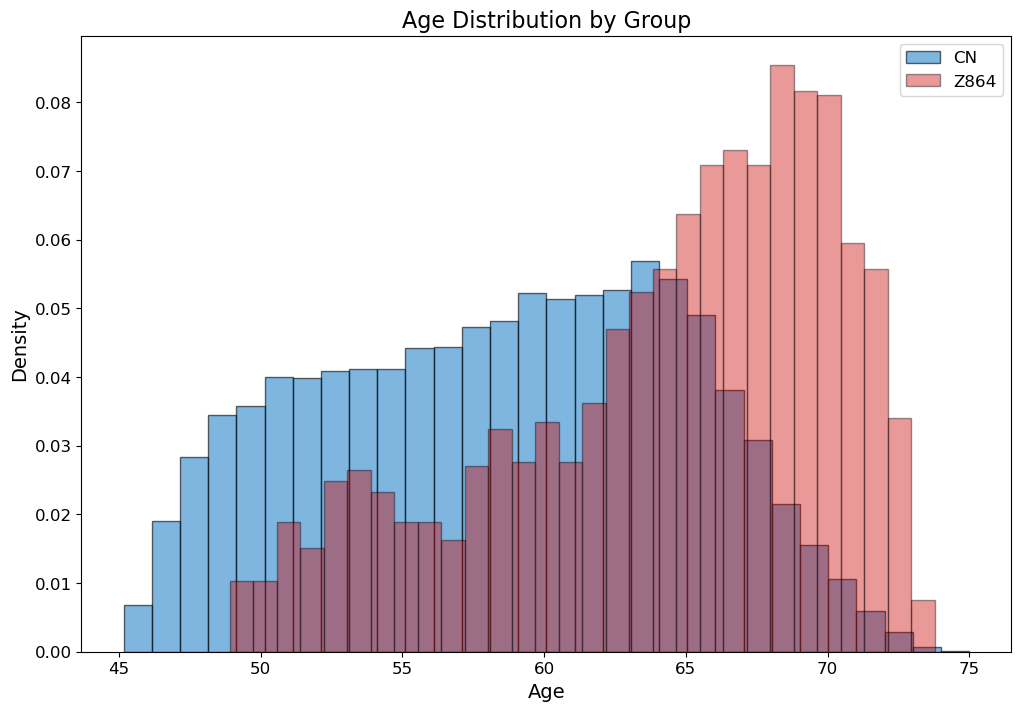

In [23]:
age_dist_plot_pred('imgs', cn_ages, disease_ages)

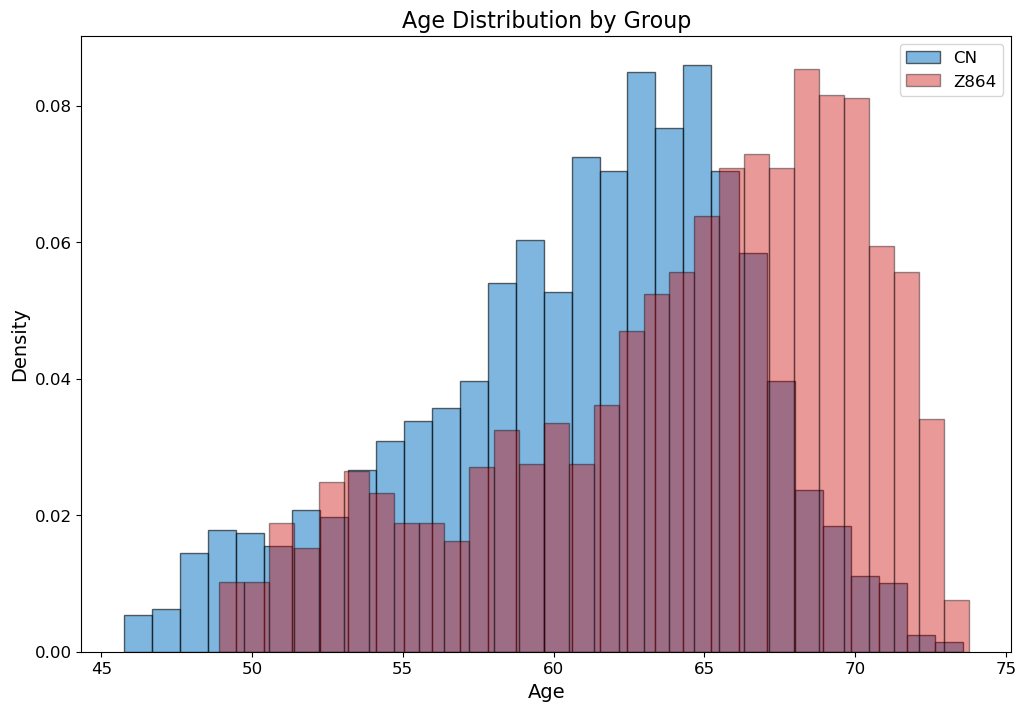

In [24]:
age_dist_plot_pred('imgs', re_cn_ages, disease_ages)

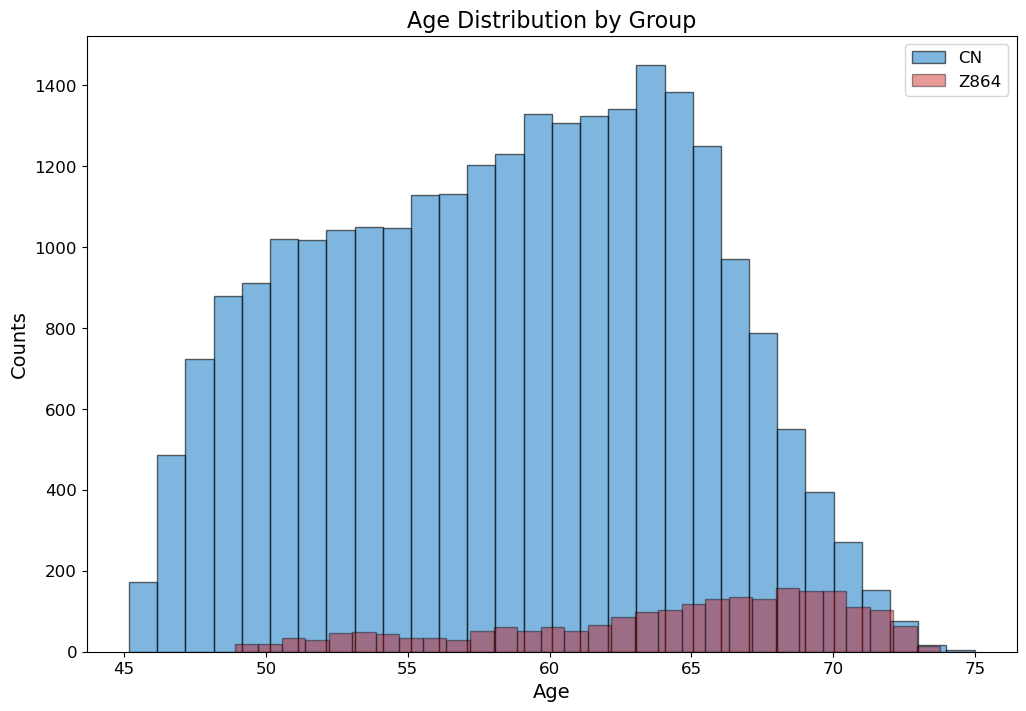

In [25]:
age_dist_plot_pred_counts('imgs', cn_ages, disease_ages)

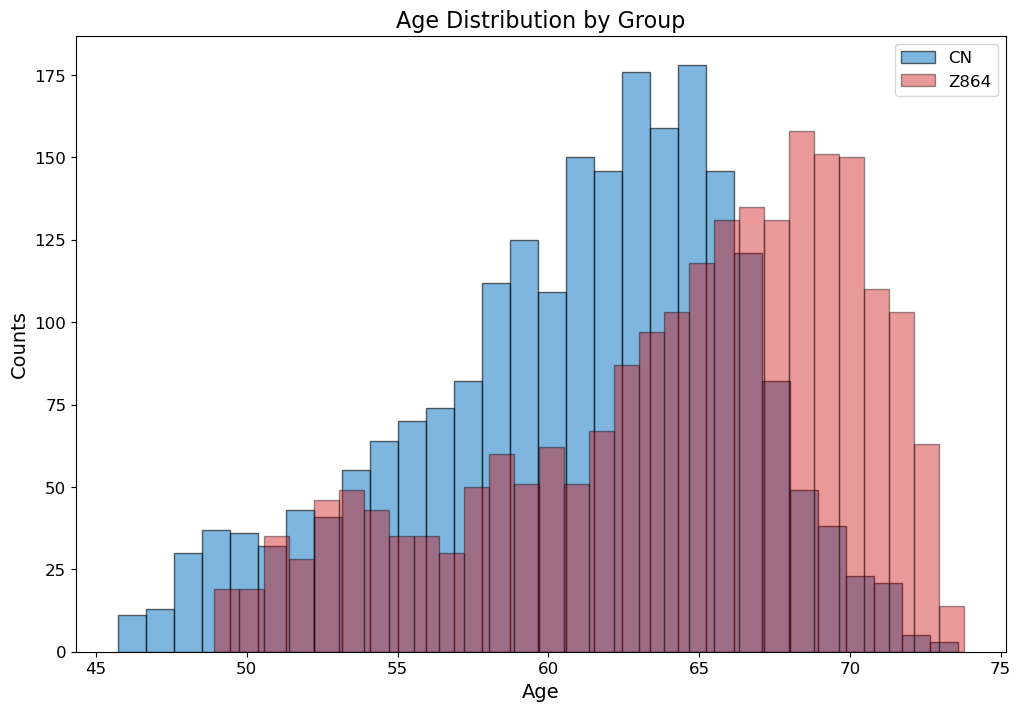

In [26]:
age_dist_plot_pred_counts('imgs', re_cn_ages, disease_ages)

In [27]:
cn_df['pred_ages'].describe()

count    25656.000000
mean        58.514240
std          6.382841
min         45.171329
25%         53.275652
50%         58.926540
75%         63.668095
max         74.988533
Name: pred_ages, dtype: float64

In [28]:
disease_df['pred_ages'].describe()

count    2231.000000
mean       64.270893
std         5.973249
min        48.903917
25%        60.481774
50%        65.680881
75%        69.001469
max        73.779533
Name: pred_ages, dtype: float64

In [29]:
re_cn_df['pred_ages'].describe()

count    2231.000000
mean       60.907722
std         5.424954
min        45.746799
25%        57.692421
50%        61.646252
75%        64.875111
max        72.973068
Name: pred_ages, dtype: float64

In [30]:
print(cn_ages['imgs']['true_ages'][20034], cn_ages['imgs']['pred_ages'][20034])

70.0 63.374294


In [31]:
print(re_cn_ages['imgs']['true_ages'][0], re_cn_ages['imgs']['pred_ages'][0])

68.0 65.35961


In [32]:
print(disease_ages['imgs']['true_ages'][0], disease_ages['imgs']['pred_ages'][0])

56.0 56.89818286895752


In [33]:
print(len(cn_ages['imgs']['true_ages']), len(re_cn_ages['imgs']['true_ages']), len(disease_ages['imgs']['true_ages']))

25656 2231 2231


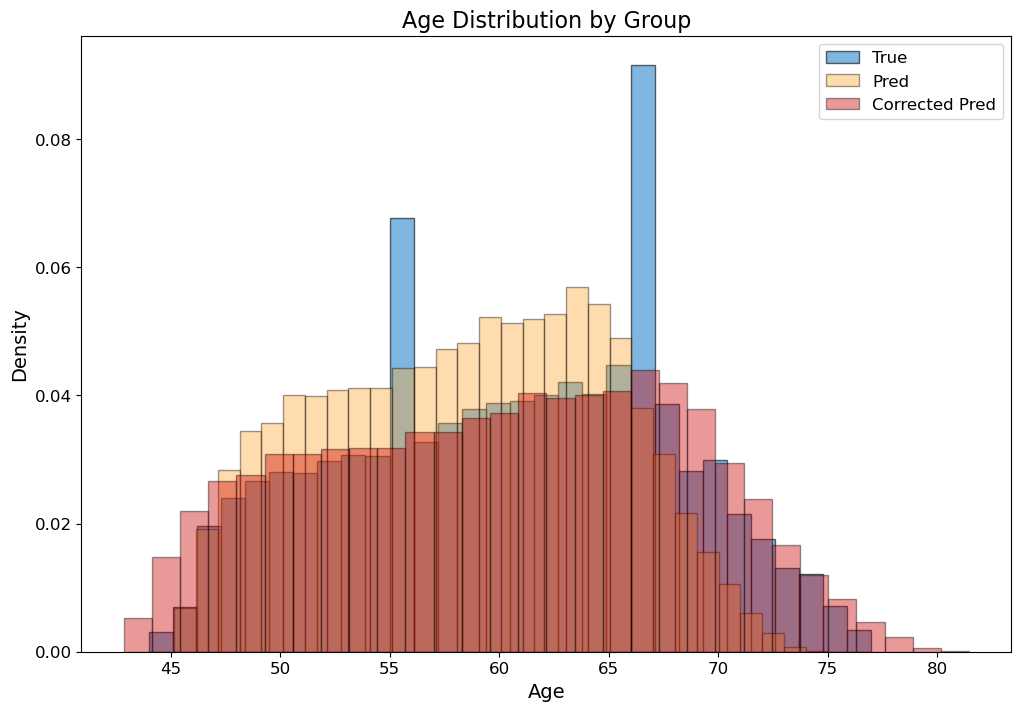

In [37]:
age_dist_plot_single_group('imgs', cn_ages)

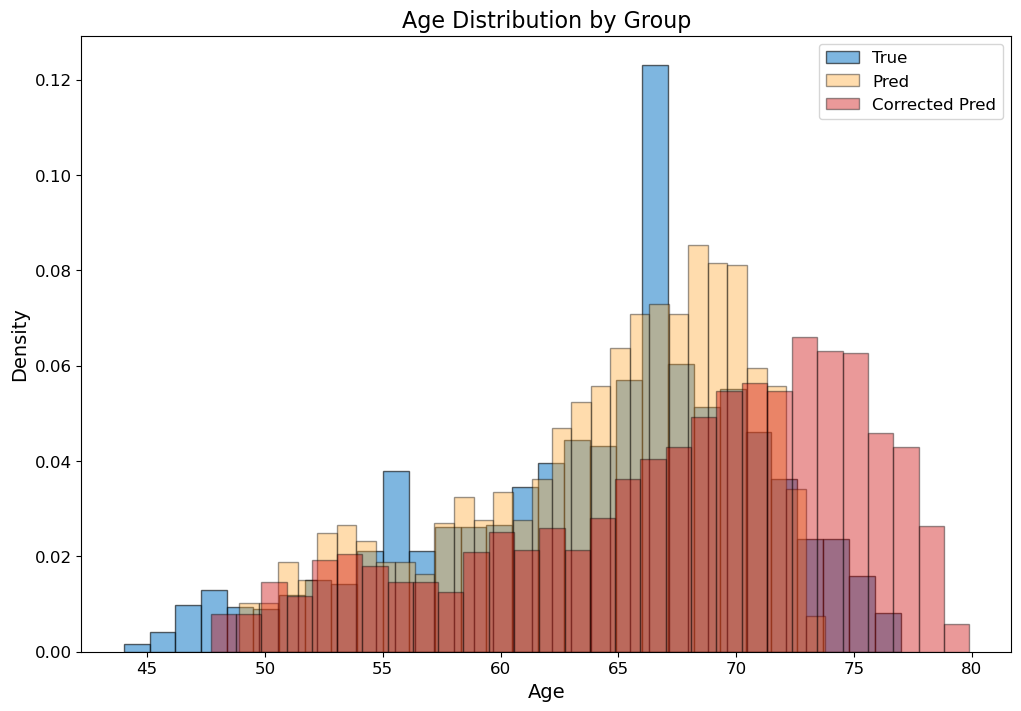

In [38]:
age_dist_plot_single_group('imgs', disease_ages)

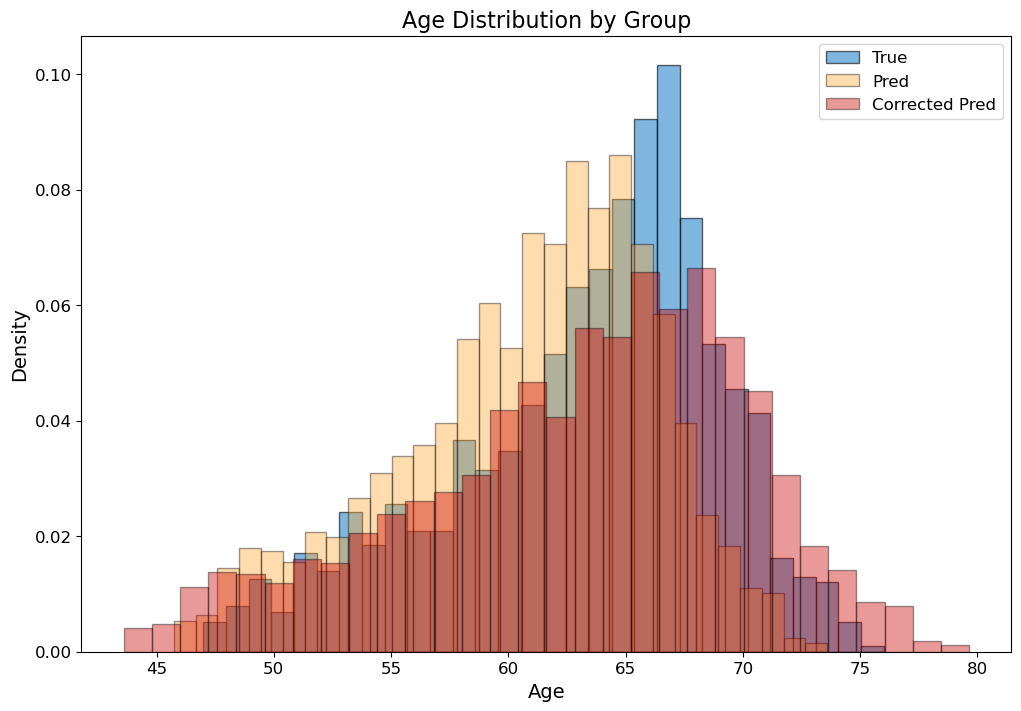

In [39]:
age_dist_plot_single_group('imgs', re_cn_ages)

# CN

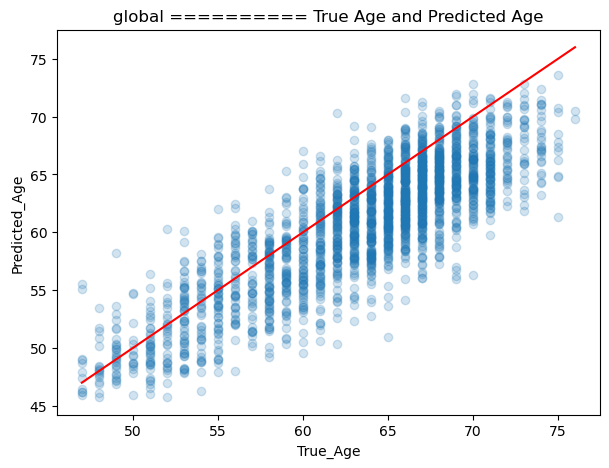

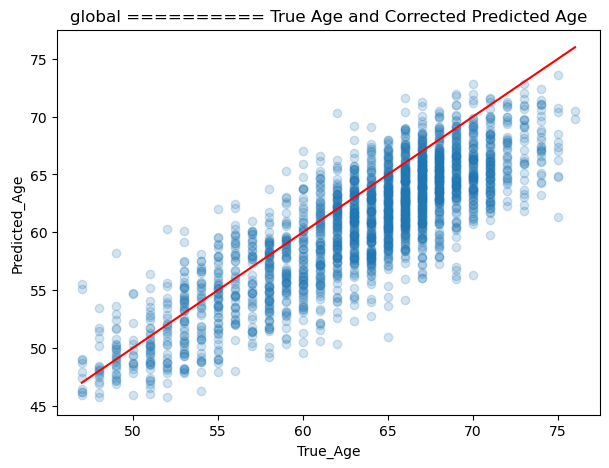

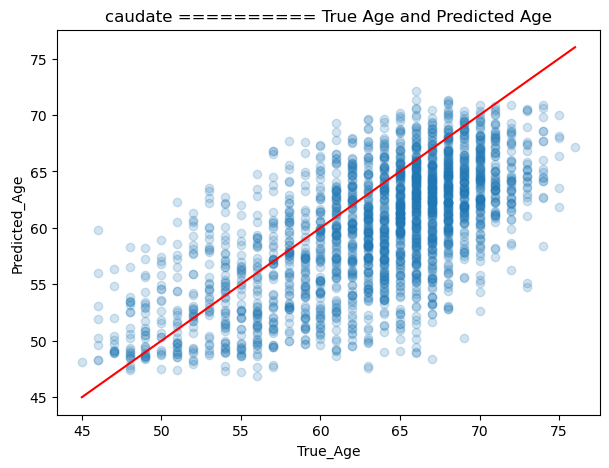

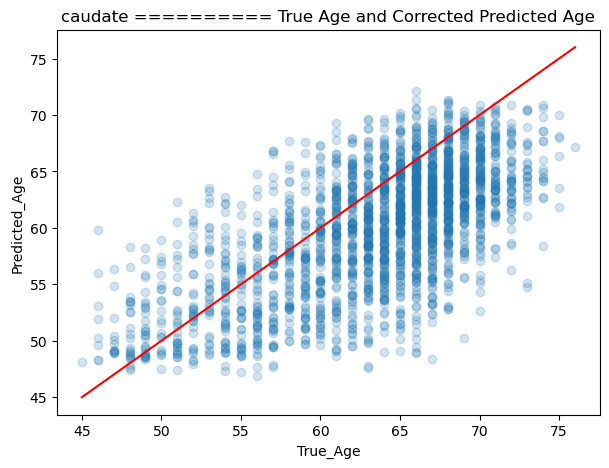

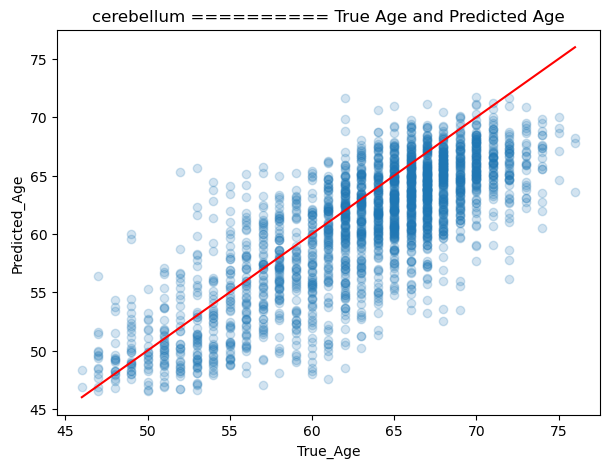

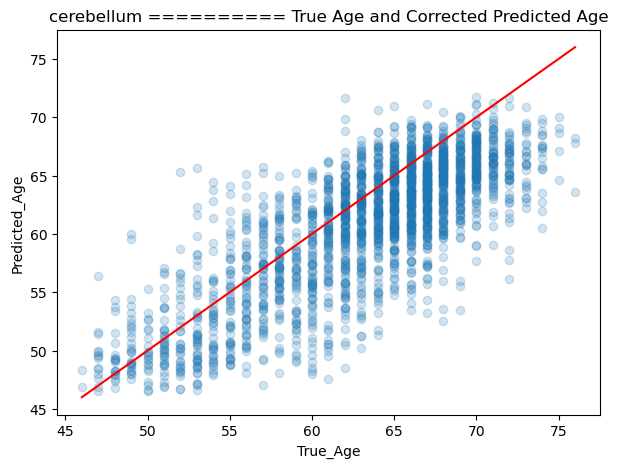

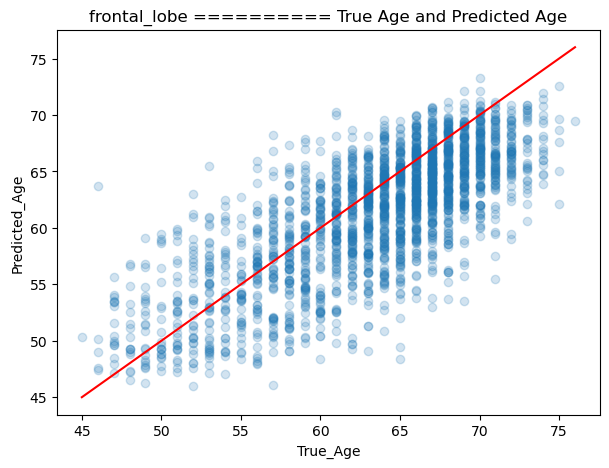

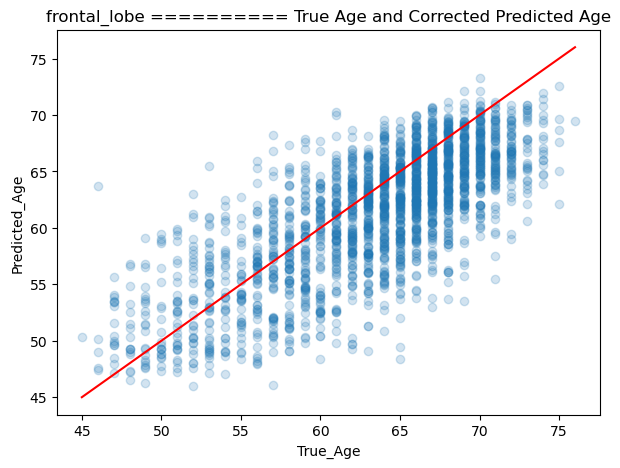

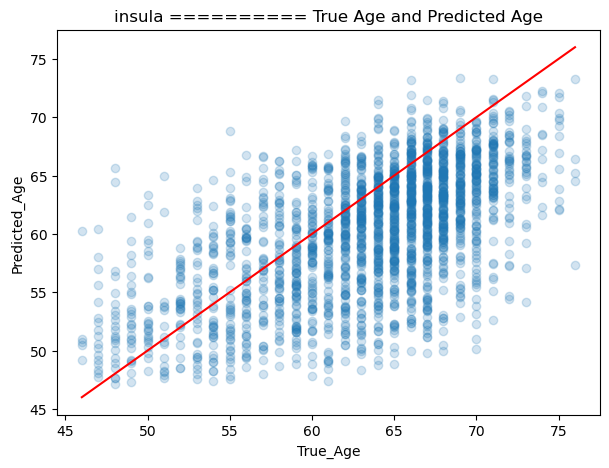

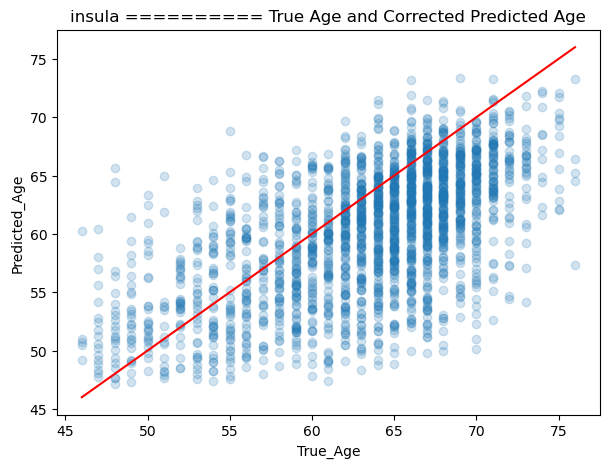

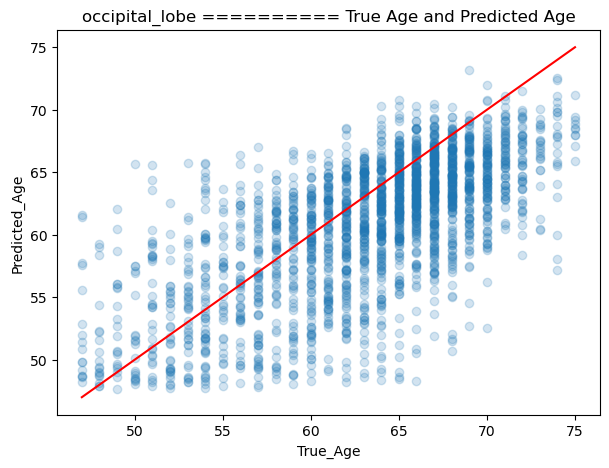

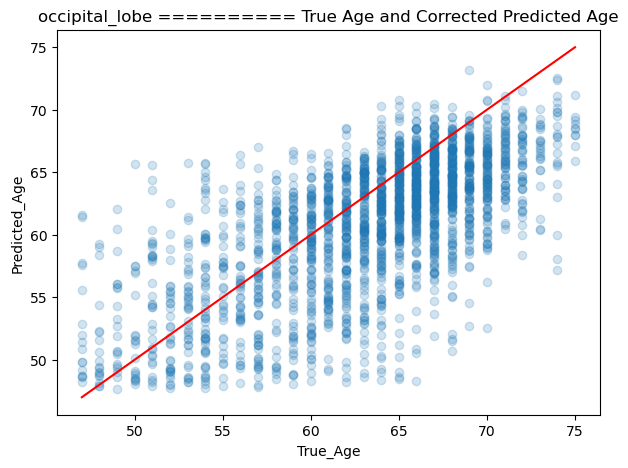

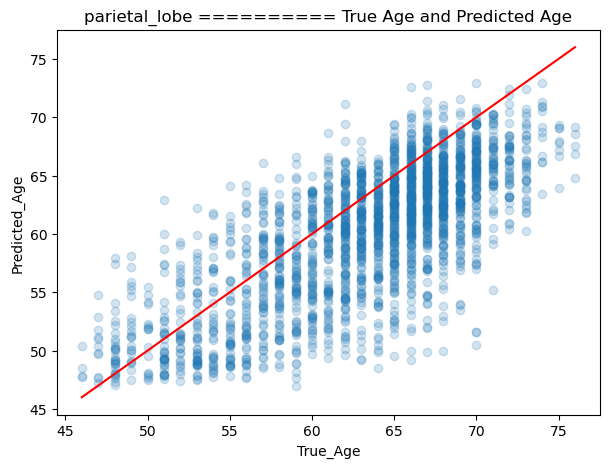

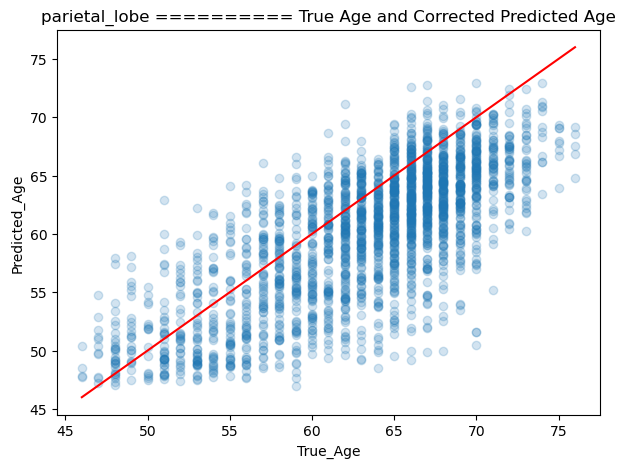

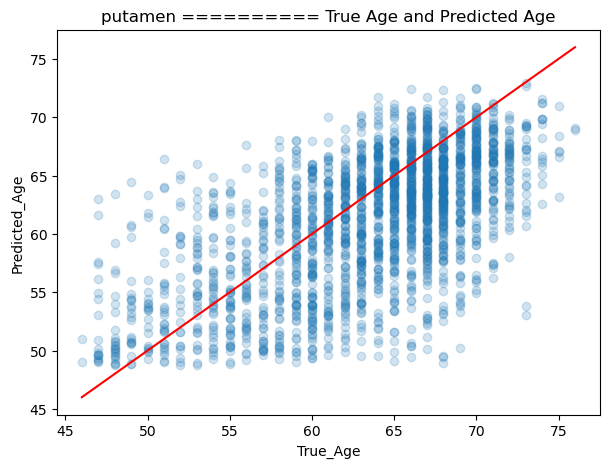

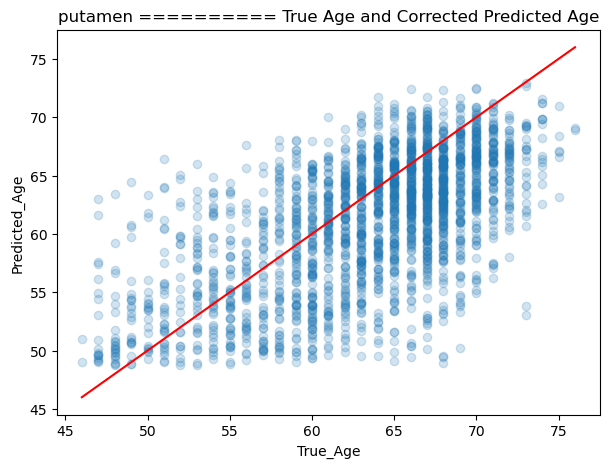

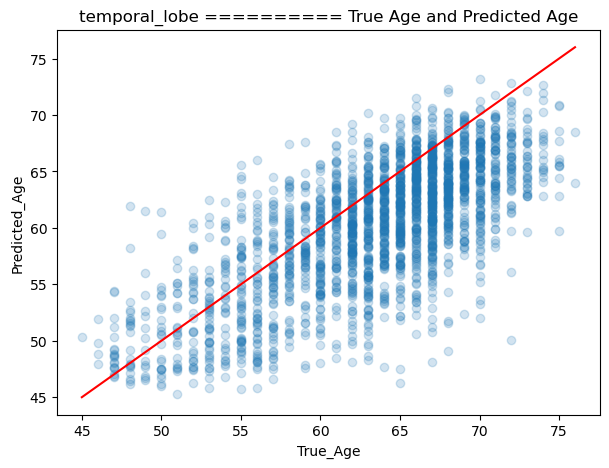

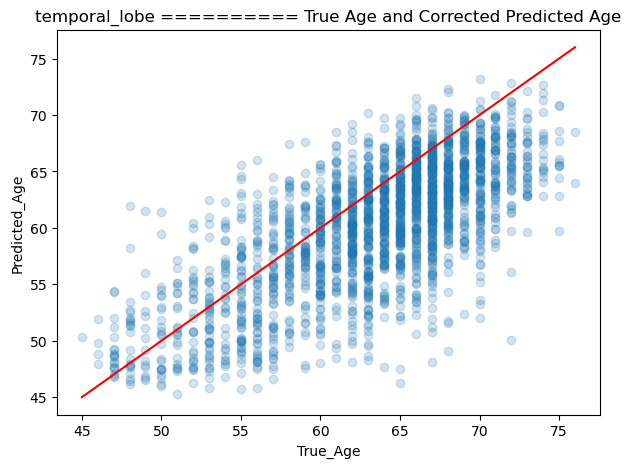

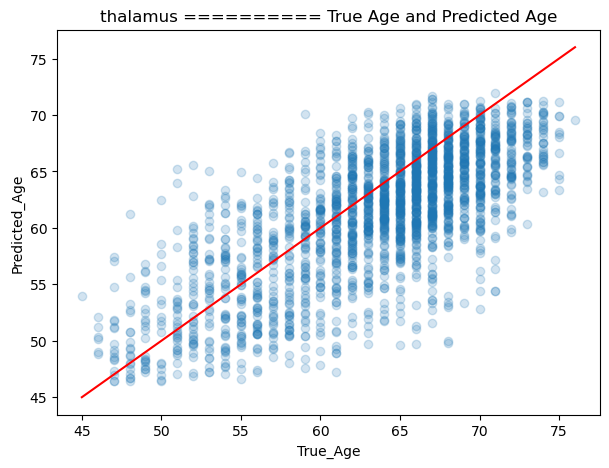

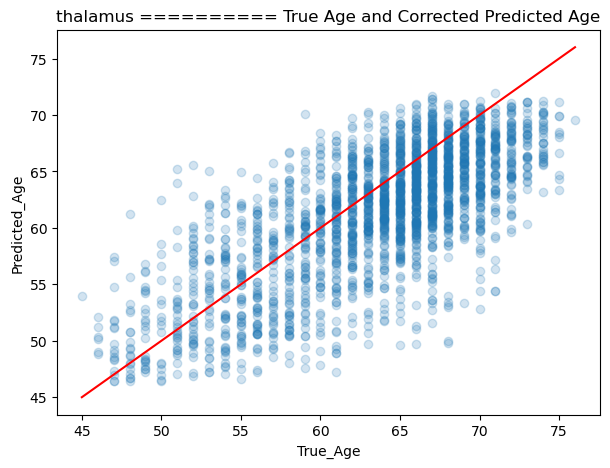

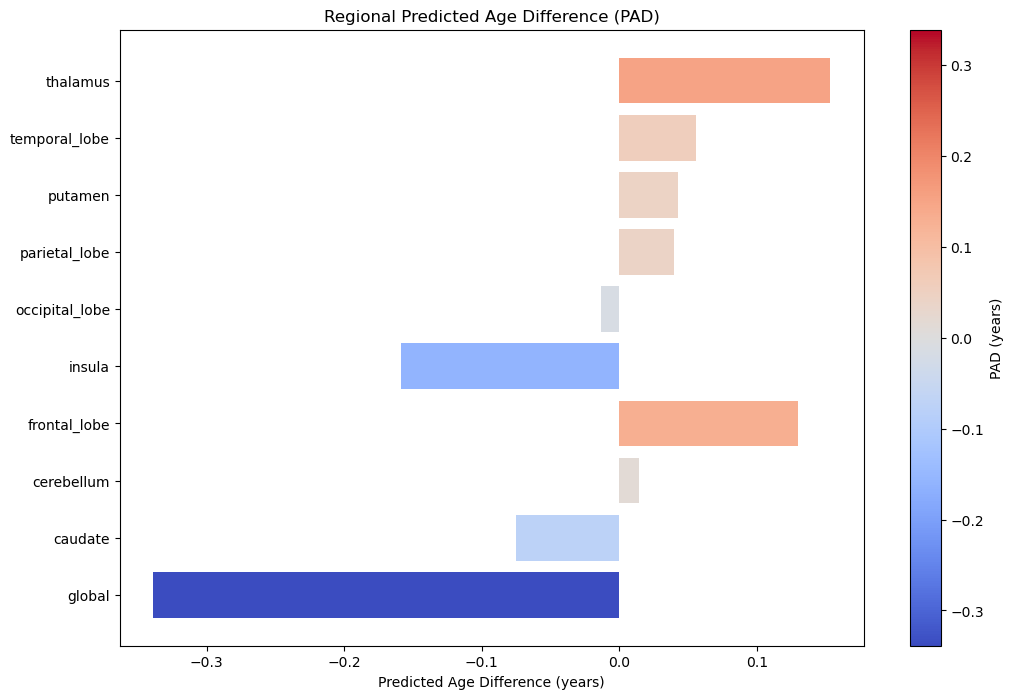

In [40]:
age_diff_groups = dict()
age_diff_dict = {}
age_diff_groups['CN'] = dict()

for key, region in regions.items():
    region_n = region
    if region == 'imgs':
        region_n = 'global'
    age_plot(re_cn_ages, region)
    age_plot_corrected(re_cn_ages, region)
    age_diff_dict[region_n] = calculate_corrected_age_diff_avg(re_cn_ages, region)
    age_diff_groups['CN'][region_n] = age_diff_dict[region_n]

# 시각화
age_diff_plot(age_diff_dict, regions.values())

# Disease

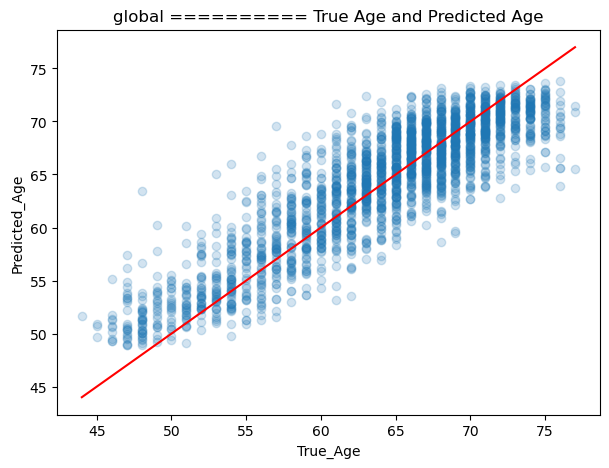

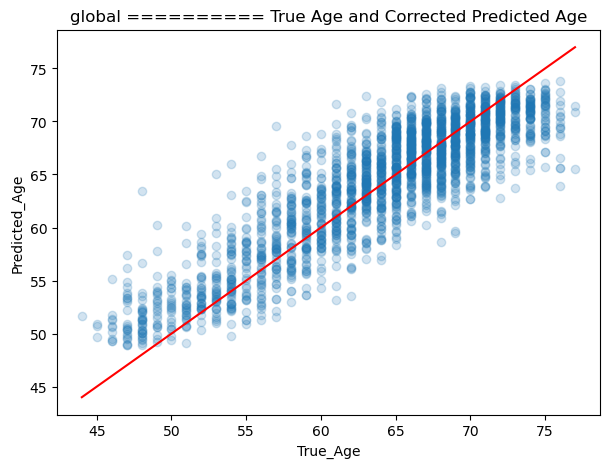

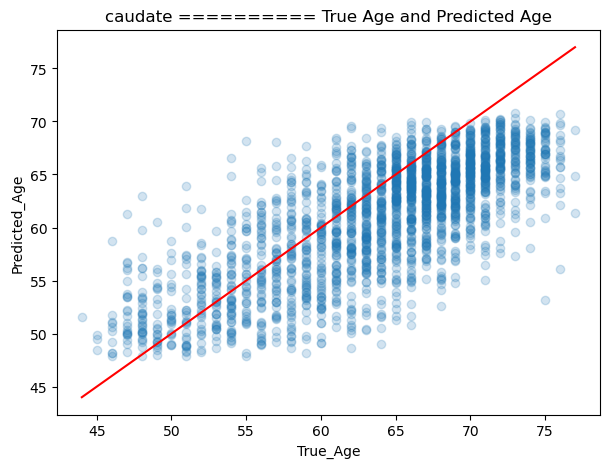

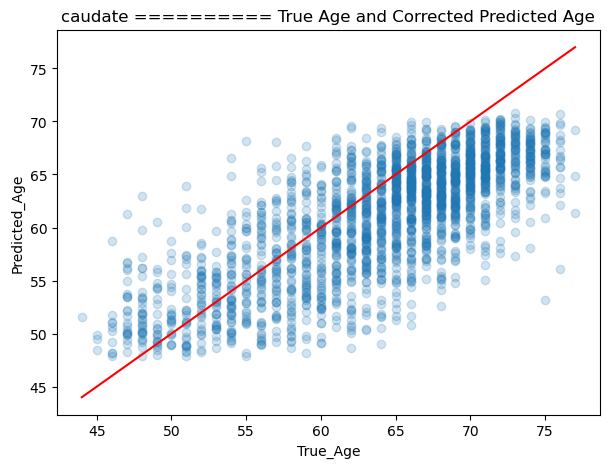

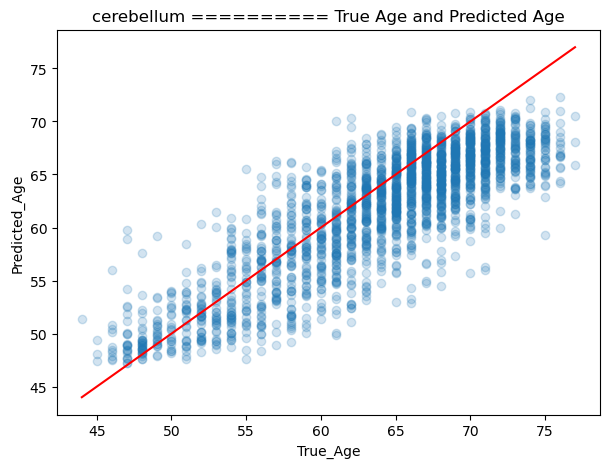

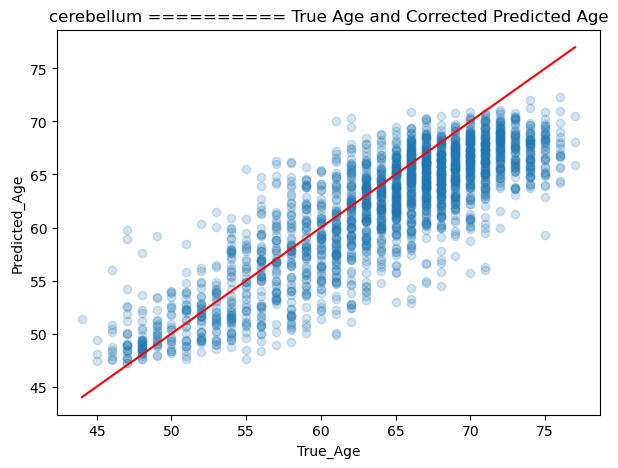

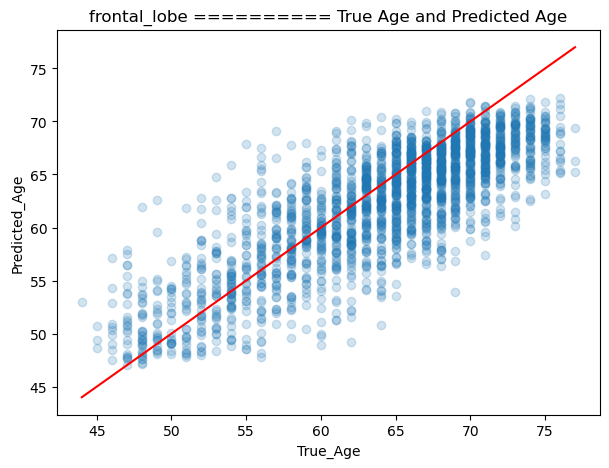

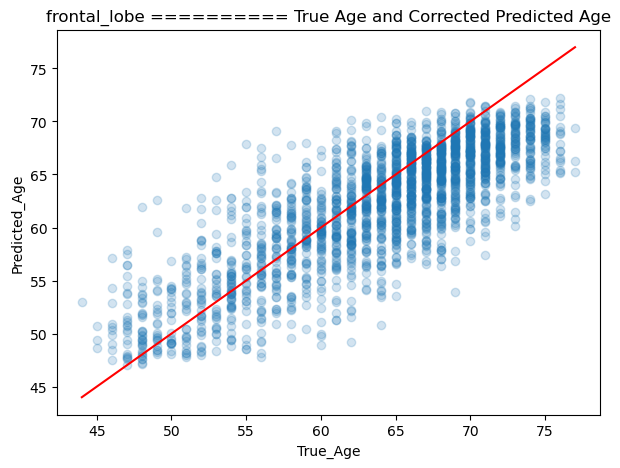

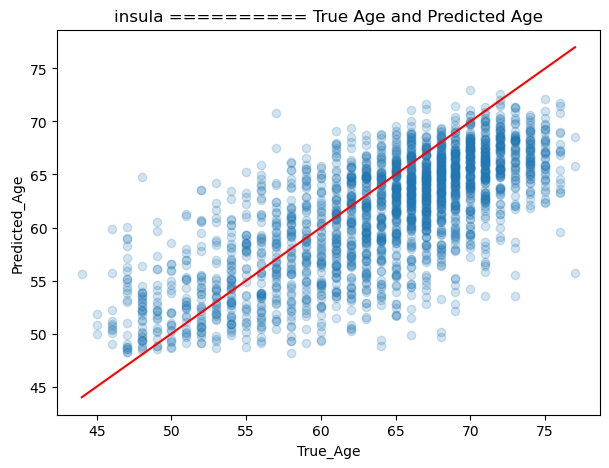

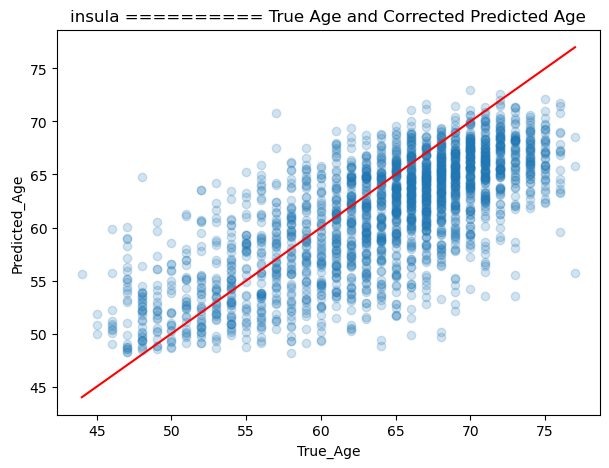

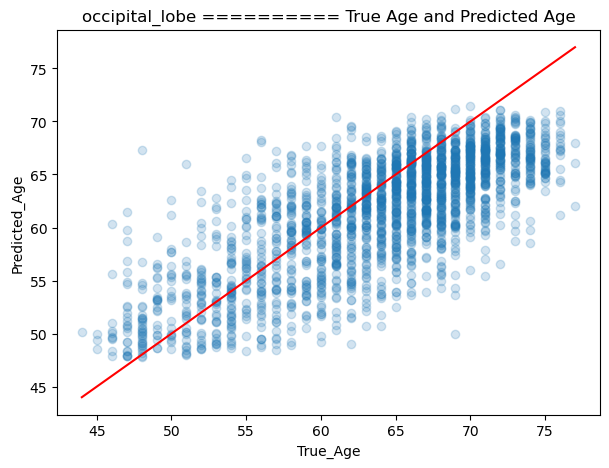

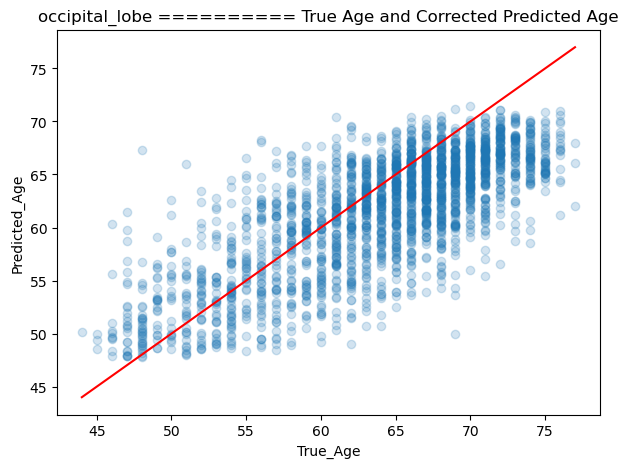

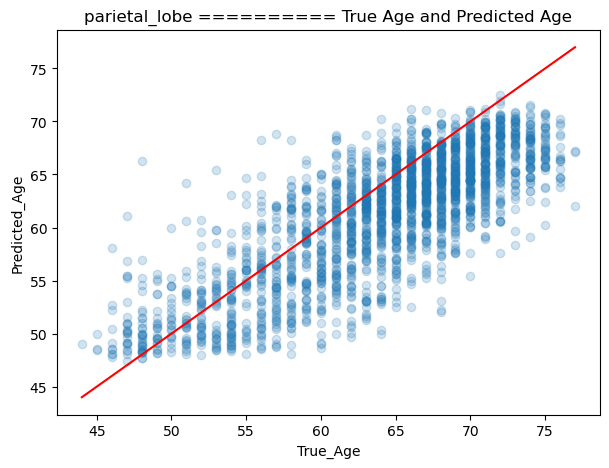

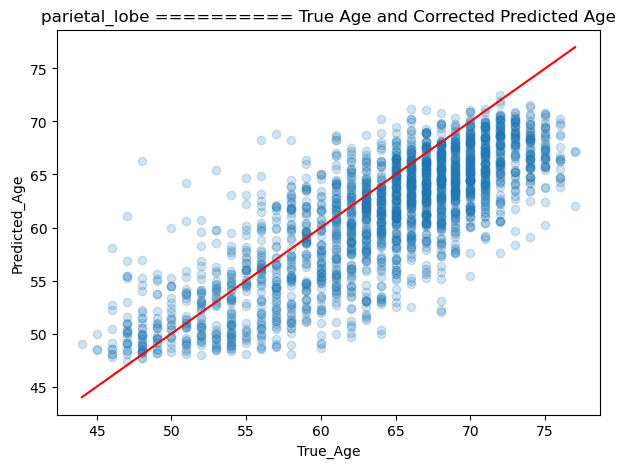

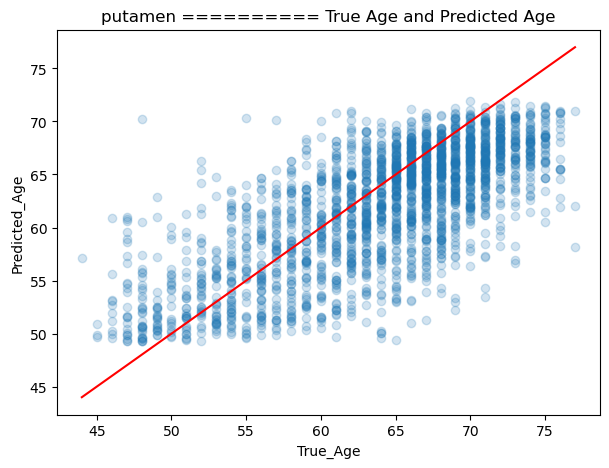

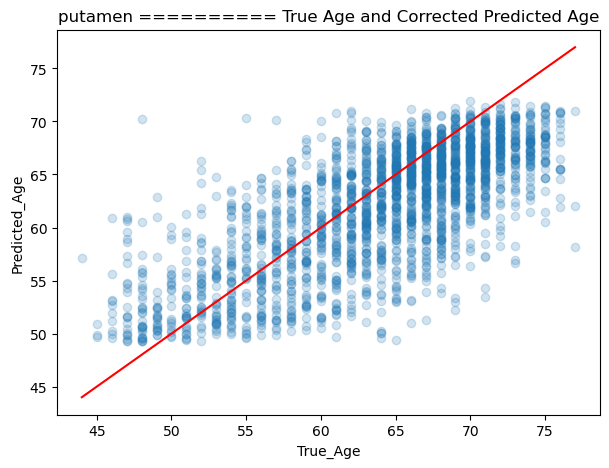

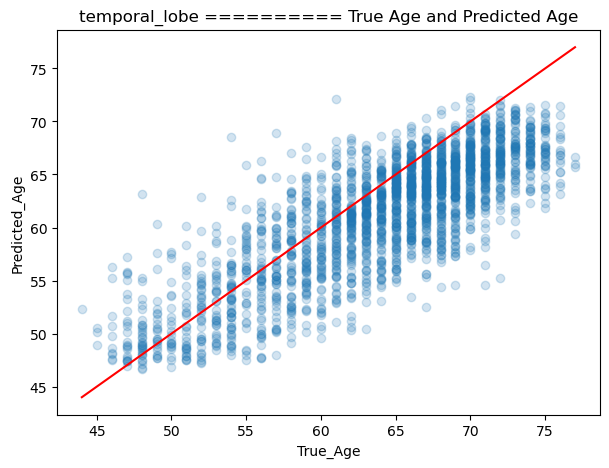

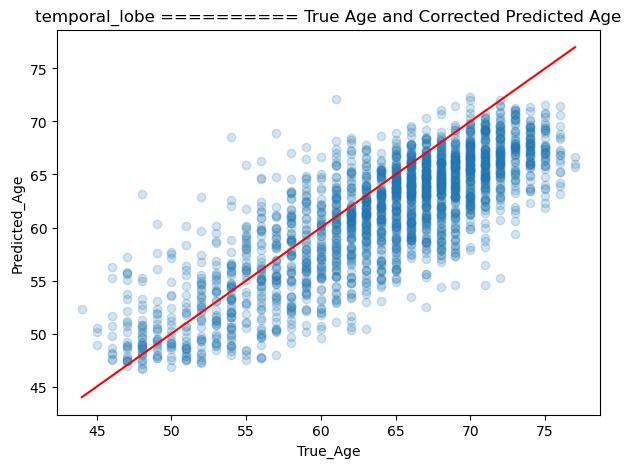

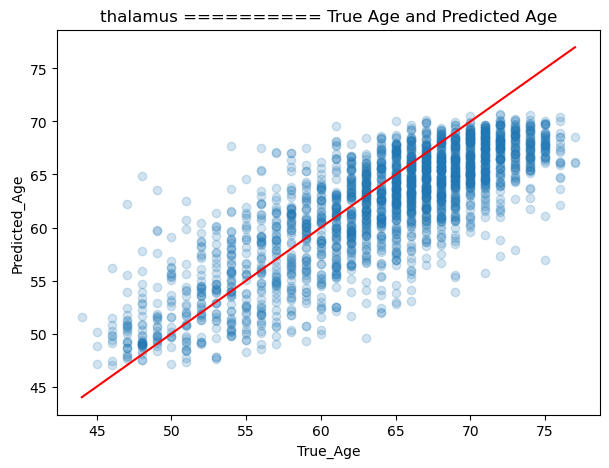

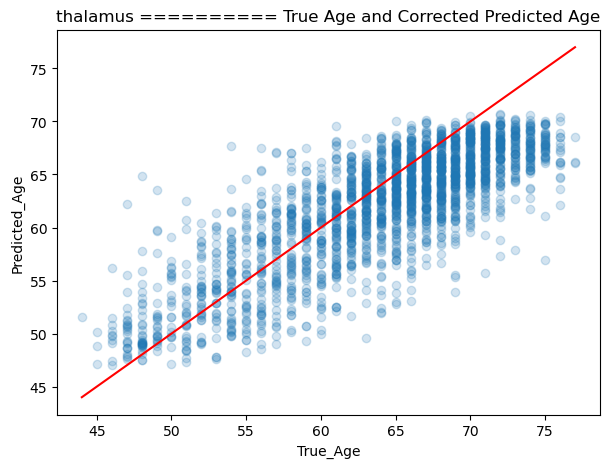

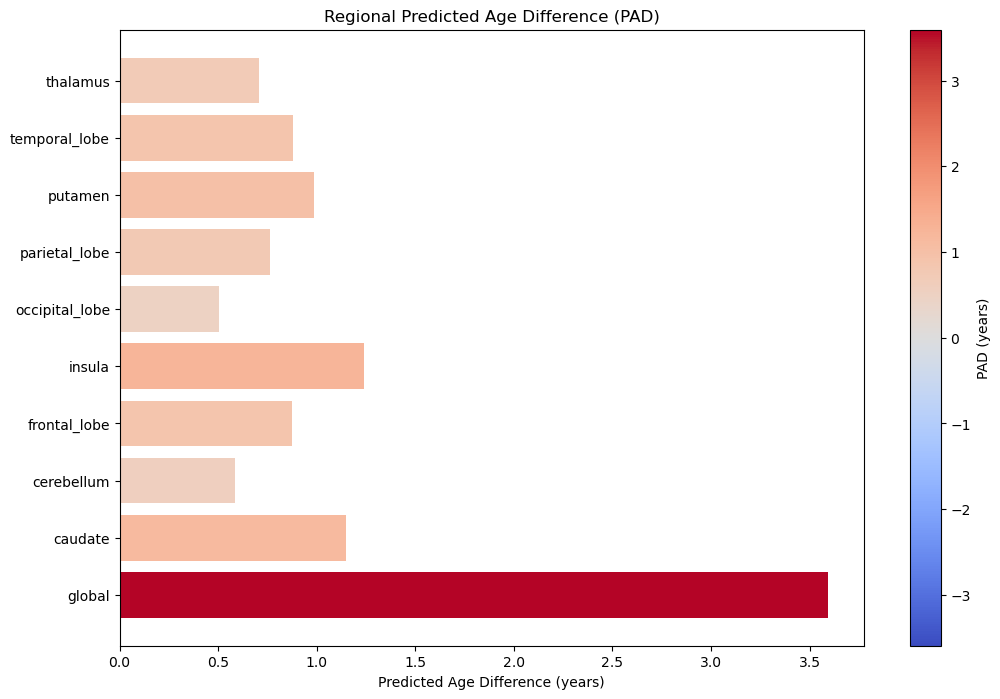

In [41]:
# 각 지역에 대한 예측 연령 차이 계산
age_diff_dict = {}
age_diff_groups[disease_u] = dict()

for key, region in regions.items():
    region_n = region
    if region == 'imgs':
        region_n = 'global'
    age_plot(disease_ages, region)
    age_plot_corrected(disease_ages, region)
    age_diff_dict[region_n] = calculate_corrected_age_diff_avg(disease_ages,region)
    age_diff_groups[disease_u][region_n] = age_diff_dict[region_n]

# 시각화
age_diff_plot(age_diff_dict, regions.values())

# Regional Predicted Age Difference (PAD) by Group

In [42]:
age_diff_groups

{'CN': {'global': -0.3388263,
  'caudate': -0.0753509,
  'cerebellum': 0.0140383,
  'frontal_lobe': 0.1302135,
  'insula': -0.1588743,
  'occipital_lobe': -0.0136524,
  'parietal_lobe': 0.0399766,
  'putamen': 0.0423656,
  'temporal_lobe': 0.0559205,
  'thalamus': 0.1530949},
 'Z864': {'global': 3.594599,
  'caudate': 1.1495279,
  'cerebellum': 0.5842995,
  'frontal_lobe': 0.8750434,
  'insula': 1.23964,
  'occipital_lobe': 0.5054148,
  'parietal_lobe': 0.7626617,
  'putamen': 0.9852666,
  'temporal_lobe': 0.8787674,
  'thalamus': 0.7087931}}

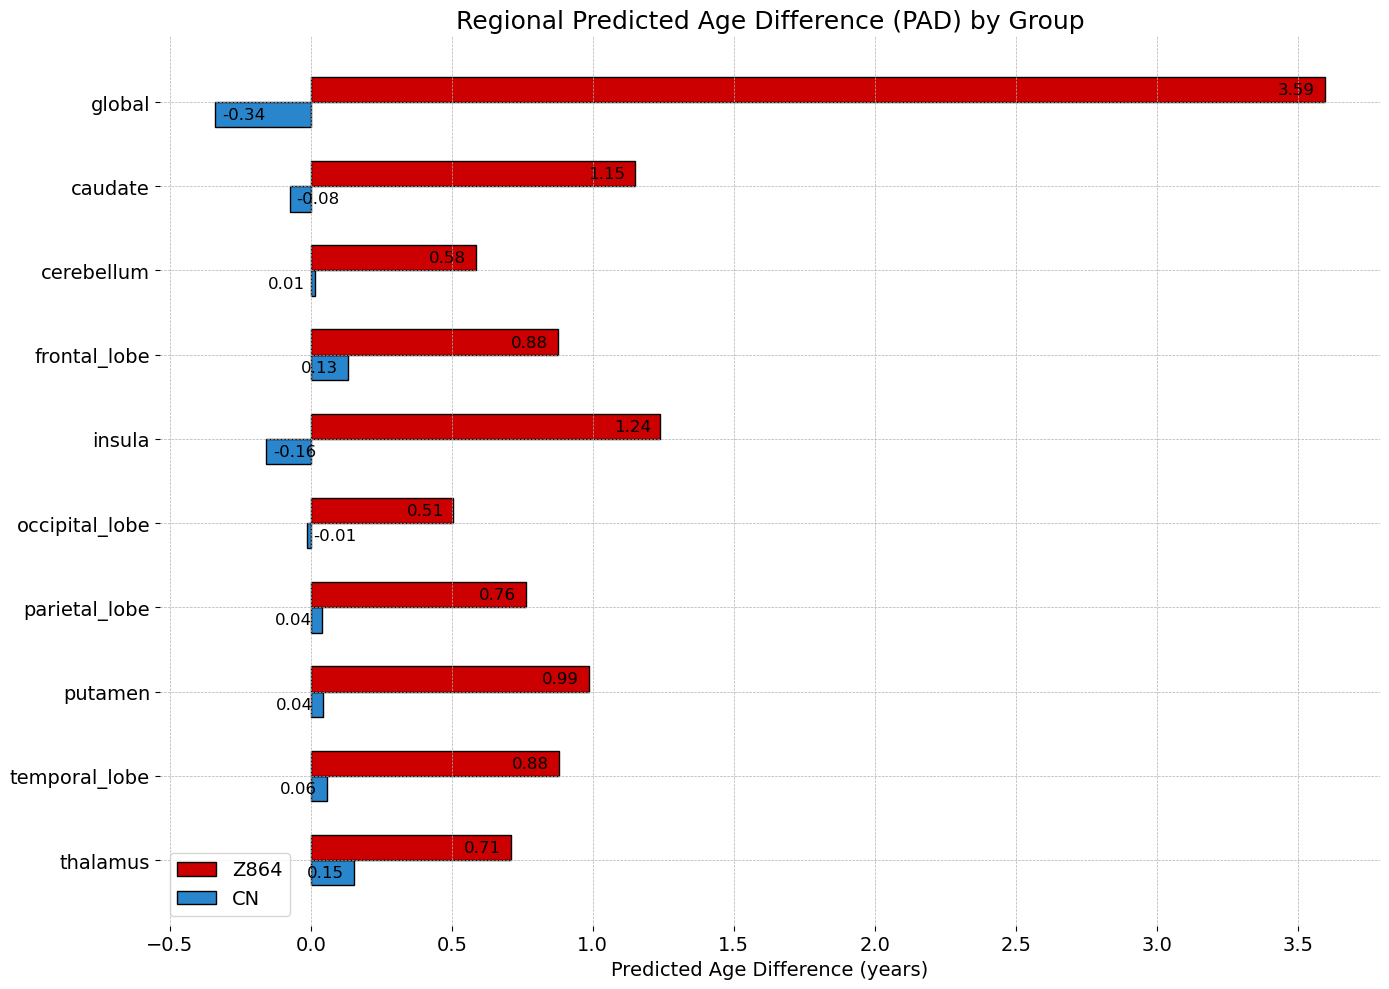

In [43]:
def multi_group_age_diff_plot(age_diff_dict, groups, regions):
    fig, ax = plt.subplots(figsize=(14, 10))

    colors = {
        groups[0]: '#2986cc',   
        groups[1]: '#cc0000'    
    }

    bar_width = 0.3  
    index = np.arange(len(regions))

    # 각 그룹에 대해 PAD 값을 시각화
    for i, group in enumerate(groups):
        pad_values = [age_diff_dict[group][region] for region in regions]
        bar_positions = index + i * bar_width
        
        bars = ax.barh(bar_positions, pad_values, bar_width, label=group, color=colors[group], edgecolor='black')
        
        # 막대에 값 표시 (애너테이션)
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width + 0.1 if width < 0 else width - 0.1
            ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
                    va='center', ha='center', color='black', fontsize=12)

    # y축 정렬 및 스타일 설정
    ax.set_yticks(index + bar_width * (len(groups) - 1) / 2)
    ax.set_yticklabels(regions, fontsize=14)
    ax.set_xlabel('Predicted Age Difference (years)', fontsize=14)
    ax.set_title('Regional Predicted Age Difference (PAD) by Group', fontsize=18)
    # 범례 순서 뒤집기
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], fontsize=14)
    
    # x축 눈금 폰트 크기 설정
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # 그리드와 스타일 설정
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    
    plt.tight_layout()
    plt.show()

regions_l = list(regions.values())
regions_l.pop(0)
regions_l.insert(0, 'global')
regions_l = regions_l[::-1]
multi_group_age_diff_plot(age_diff_groups, ['CN', disease_u], regions_l)